# Load packages and set path

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import PIL
import scipy
import gc
from PIL import Image
# !pip install scikit-image
import pydicom
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure
from skimage.transform import resize

PATH = "../input/osic-pulmonary-fibrosis-progression/"
PROCESSED_DATA_PATH = "../input/osic-pulmonary-fibrosis-progression/archive/mask_noise/mask_noise/"
META_DATA_PATH = "/Users/paritoshgupta/Desktop/"

print(f"# Changing directory to {PATH}")
# os.chdir(PATH)
print(f"\n** Files present in PATH --> {list(os.listdir(PATH))}")

# Changing directory to ../input/osic-pulmonary-fibrosis-progression/

** Files present in PATH --> ['.DS_Store', 'archive', 'test', 'test.csv', 'train', 'train.csv', 'sub_df.csv', 'ads_4_folds.csv', 'lung_mask_1mm', 'sample_submission.csv']


# EDA

In [2]:
df_train = pd.read_csv(f'{PATH}/train.csv')
df_test = pd.read_csv(f'{PATH}/test.csv')
print(f"Train rows --> {df_train.shape}")
print(f"Test rows --> {df_test.shape}")
print("\n#######################")
print(f"#### Train Missing ####\n{df_train.isna().sum()} ")
print("#######################")
print("\n#######################")
print(f"#### Test Missing ####\n{df_test.isna().sum()}")
print("#######################")
df_train.head()

Train rows --> (1549, 7)
Test rows --> (5, 7)

#######################
#### Train Missing ####
Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64 
#######################

#######################
#### Test Missing ####
Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64
#######################


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


## Basic EDA

In [3]:
print("#######################")
print("#### Train ####")
print(f"Train Shape --> {df_train.shape}")
print(f"Unique Patient --> {df_train.Patient.nunique()}")
print(f"Unique Weeks --> {df_train.Weeks.nunique()}")
print(f"Unique Percent --> {df_train.Percent.nunique()}")
print(f"Unique Age --> {df_train.Age.nunique()}")
print(f"Unique Sex --> {df_train.Sex.nunique()}")
print(f"Unique SmokingStatus --> {df_train.SmokingStatus.nunique()}")
print(f"Unique Target Value (FVC)) --> {df_train.FVC.nunique()}")
print("#######################")
print("\n#### Test ####")
print(f"Test Shape --> {df_test.shape}")
print(f"Unique Patient --> {df_test.Patient.nunique()}")
print(f"Unique Weeks --> {df_test.Weeks.nunique()}")
print(f"Unique Percent --> {df_test.Percent.nunique()}")
print(f"Unique Age --> {df_test.Age.nunique()}")
print(f"Unique Sex --> {df_test.Sex.nunique()}")
print(f"Unique SmokingStatus --> {df_test.SmokingStatus.nunique()}")

print("\n######## Train Summary ######")
print(df_train.describe())
df_train.head()

#######################
#### Train ####
Train Shape --> (1549, 7)
Unique Patient --> 176
Unique Weeks --> 112
Unique Percent --> 1536
Unique Age --> 34
Unique Sex --> 2
Unique SmokingStatus --> 3
Unique Target Value (FVC)) --> 1202
#######################

#### Test ####
Test Shape --> (5, 7)
Unique Patient --> 5
Unique Weeks --> 4
Unique Percent --> 5
Unique Age --> 3
Unique Sex --> 1
Unique SmokingStatus --> 2

######## Train Summary ######
             Weeks          FVC      Percent          Age
count  1549.000000  1549.000000  1549.000000  1549.000000
mean     31.861846  2690.479019    77.672654    67.188509
std      23.247550   832.770959    19.823261     7.057395
min      -5.000000   827.000000    28.877577    49.000000
25%      12.000000  2109.000000    62.832700    63.000000
50%      28.000000  2641.000000    75.676937    68.000000
75%      47.000000  3171.000000    88.621065    72.000000
max     133.000000  6399.000000   153.145378    88.000000


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [4]:
df_test

# initial FVC, same week - image + Meta Data ----> All Possible FVC Predict

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [5]:
print(f"Number of rows with FVC measurement BEFORE ct scan --> {df_train[df_train.Weeks <0].shape}")
print(f"Number of unique patients with FVC measurement BEFORE ct scan --> {len(df_train[df_train.Weeks <0].Patient.unique())}")
df_train[df_train.Weeks <0]

Number of rows with FVC measurement BEFORE ct scan --> (11, 7)
Number of unique patients with FVC measurement BEFORE ct scan --> 11


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
80,ID00023637202179104603099,-3,1536,65.306122,71,Female,Ex-smoker
175,ID00051637202185848464638,-1,1697,81.645417,73,Female,Ex-smoker
261,ID00076637202199015035026,-4,2298,52.749977,51,Male,Never smoked
297,ID00086637202203494931510,-5,3367,117.628563,65,Female,Never smoked
323,ID00093637202205278167493,-1,3695,84.958153,69,Male,Ex-smoker
438,ID00122637202216437668965,-4,2581,69.501293,58,Male,Ex-smoker
534,ID00133637202223847701934,-2,3195,92.856312,83,Male,Never smoked
840,ID00222637202259066229764,-1,2644,62.832700,70,Male,Ex-smoker
894,ID00233637202260580149633,-3,3829,100.784376,68,Male,Ex-smoker


## Train, Test patient split

In [6]:
common_patients = list(set([x for x in df_train.Patient.values if x in df_test.Patient.values]))
df_train[df_train.Patient.isin(common_patients)].head()
train_only_patients = list(set([x for x in df_train.Patient.values if x not in df_test.Patient.values]))
print(f"Train only patients count --> {len(train_only_patients)}")
print(f"Test only patients count --> {len(common_patients)}")
test_patients = common_patients
print("\n##############################################")
print("##### Test Patients data present... #####")
print(f"# Number of rows present for Test Patients --> {df_train[df_train.Patient.isin(common_patients)].shape}")
print("##############################################")
print(test_patients)
# df_train[df_train.Patient.isin(common_patients)]

Train only patients count --> 171
Test only patients count --> 5

##############################################
##### Test Patients data present... #####
# Number of rows present for Test Patients --> (45, 7)
##############################################
['ID00426637202313170790466', 'ID00421637202311550012437', 'ID00419637202311204720264', 'ID00423637202312137826377', 'ID00422637202311677017371']


## N Weeks, N images, Meta (RAW) Distribution

In [7]:
patient_df = df_train[['Patient', 'Age', 'Sex', 'SmokingStatus']].drop_duplicates().reset_index(drop=True)
print(f"Patient level meta data shape --> {patient_df.shape}")
df_n_weeks_tmp = pd.DataFrame(df_train[['Patient', 'Weeks']].drop_duplicates()['Patient'].value_counts().reset_index())
df_n_weeks_tmp.columns = ["Patient", "n_weeks"]
print(f"Patient level n weeks data shape --> {df_n_weeks_tmp.shape}")
df_n_weeks_tmp.head()

# Create unique patient lists and properties
train_dir = "../input/osic-pulmonary-fibrosis-progression/train/"

patients_ids = os.listdir(train_dir)
print(f"N Directories --> {len(patients_ids)}")

if '.DS_Store' in patients_ids:
    patients_ids.remove('.DS_Store')
patients_ids = sorted(patients_ids)

no_of_instances = []
for i, patient_id in enumerate(patients_ids):
    n_images = len(os.listdir(train_dir + patient_id))
    if i %16 == 0:
        if i == 0:
            print("\n*------This is sample only for few patients-----*")
        print(f" {patient_id} N Images --> {n_images}")
    no_of_instances.append(n_images)
print("*-----------------------------------------------*\n")
df_n_images_tmp = pd.DataFrame({"Patient": patients_ids, "n_images_dicom": no_of_instances})
print(f"* Patient level n images data shape --> {df_n_images_tmp.shape}")

df_patient = pd.merge(patient_df, df_n_weeks_tmp, on="Patient", how="inner")
df_patient = pd.merge(df_patient, df_n_images_tmp, on="Patient", how="inner")
print(f"* Patient level ALL META INFO data shape --> {df_patient.shape}")
print("\n##############################################")
print("#### Patient meta data summary ####")
print(f"### Continuous Columns ####")
print(df_patient.describe())
print("##############################################")

print("\n##############################################")
print(f"### Categorical Columns ####")
print(f"* Distribution of SEX across 176 patients --> {dict(df_patient.Sex.value_counts())}")
print(f"* Distribution of SMOKING STATUS across 176 patients --> {dict(df_patient.SmokingStatus.value_counts())}")
print("##############################################")
df_patient.head(9)

Patient level meta data shape --> (176, 4)
Patient level n weeks data shape --> (176, 2)
N Directories --> 177

*------This is sample only for few patients-----*
 ID00007637202177411956430 N Images --> 30
 ID00038637202182690843176 N Images --> 346
 ID00078637202199415319443 N Images --> 1018
 ID00117637202212360228007 N Images --> 30
 ID00136637202224951350618 N Images --> 404
 ID00186637202242472088675 N Images --> 408
 ID00224637202259281193413 N Images --> 54
 ID00267637202270790561585 N Images --> 63
 ID00309637202282195513787 N Images --> 469
 ID00344637202287684217717 N Images --> 201
 ID00392637202302319160044 N Images --> 56
*-----------------------------------------------*

* Patient level n images data shape --> (176, 2)
* Patient level ALL META INFO data shape --> (176, 6)

##############################################
#### Patient meta data summary ####
### Continuous Columns ####
              Age     n_weeks  n_images_dicom
count  176.000000  176.000000      176.000000


,Patient,Age,Sex,SmokingStatus,n_weeks,n_images_dicom
0,ID00007637202177411956430,79,Male,Ex-smoker,9,30
1,ID00009637202177434476278,69,Male,Ex-smoker,9,394
2,ID00010637202177584971671,60,Male,Ex-smoker,9,106
3,ID00011637202177653955184,72,Male,Ex-smoker,9,31
4,ID00012637202177665765362,65,Male,Never smoked,9,49
5,ID00014637202177757139317,56,Male,Ex-smoker,9,31
6,ID00015637202177877247924,71,Male,Ex-smoker,8,295
7,ID00019637202178323708467,83,Female,Ex-smoker,9,29
8,ID00020637202178344345685,66,Female,Never smoked,9,493


## Duplicate rows

### ALL Patients

In [8]:
df_dup_rows = df_train.groupby(['Patient', 
    'Weeks']).size().reset_index().rename(
    columns={0:'records'}).sort_values('records', 
    ascending=False).reset_index(drop=True)
df_dup_rows = df_dup_rows[df_dup_rows['records'] > 1].reset_index(drop=True)
df_dup_rows = pd.merge(df_dup_rows, df_train, how="inner", on =["Patient", "Weeks"])
print(f"Duplicates rows in ALL PATIENTS @ (Patient + Week level) --> {df_dup_rows.shape}")
df_dup_rows

Duplicates rows in ALL PATIENTS @ (Patient + Week level) --> (14, 8)


,Patient,Weeks,records,FVC,Percent,Age,Sex,SmokingStatus
0,ID00199637202248141386743,5,2,2672,64.728682,62,Male,Ex-smoker
1,ID00199637202248141386743,5,2,2683,64.995155,62,Male,Ex-smoker
2,ID00125637202218590429387,8,2,2349,53.757781,65,Male,Never smoked
3,ID00125637202218590429387,8,2,2584,59.135848,65,Male,Never smoked
4,ID00240637202264138860065,5,2,2991,78.421605,63,Male,Ex-smoker
5,ID00240637202264138860065,5,2,3132,82.118511,63,Male,Ex-smoker
6,ID00068637202190879923934,11,2,2794,82.633385,73,Male,Ex-smoker
7,ID00068637202190879923934,11,2,2827,83.609369,73,Male,Ex-smoker
8,ID00048637202185016727717,9,2,1375,60.059404,70,Female,Never smoked
9,ID00048637202185016727717,9,2,1477,64.514720,70,Female,Never smoked


### Test Patients

In [9]:
df_dup_rows_test = df_dup_rows[df_dup_rows.Patient.isin(common_patients)].reset_index(drop=True)
print(f"Duplicates rows in TEST PATIENTS @ (Patient + Week level) --> {df_dup_rows_test.shape}")
df_dup_rows_test

Duplicates rows in TEST PATIENTS @ (Patient + Week level) --> (2, 8)


,Patient,Weeks,records,FVC,Percent,Age,Sex,SmokingStatus
0,ID00421637202311550012437,70,2,2628,78.720345,68,Male,Ex-smoker
1,ID00421637202311550012437,70,2,2719,81.446202,68,Male,Ex-smoker


In [10]:
df_train[df_train.Patient=="ID00007637202177411956430"]

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
5,ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker
6,ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker
7,ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker
8,ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker


In [14]:
df_train[df_train.FVC==827]

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
864,ID00225637202259339837603,54,827,41.884021,77,Female,Never smoked


## Test EDA

###  "test.csv"

In [11]:
df_test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


### Test Patients data present

In [12]:
print(f"N rows for TEST Patients --> {df_train[df_train.Patient.isin(common_patients)].shape}")
df_train[df_train.Patient.isin(common_patients)]

N rows for TEST Patients --> (45, 7)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
1504,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1505,ID00419637202311204720264,7,2859,66.445106,73,Male,Ex-smoker
1506,ID00419637202311204720264,9,2783,64.678814,73,Male,Ex-smoker
1507,ID00419637202311204720264,10,2719,63.191410,73,Male,Ex-smoker
1508,ID00419637202311204720264,13,2738,63.632983,73,Male,Ex-smoker
1509,ID00419637202311204720264,18,2694,62.610393,73,Male,Ex-smoker
1510,ID00419637202311204720264,31,2708,62.935763,73,Male,Ex-smoker
1511,ID00419637202311204720264,43,2793,64.911221,73,Male,Ex-smoker
1512,ID00419637202311204720264,59,2727,63.377336,73,Male,Ex-smoker
1513,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker


## Train vs Test comparison

In [13]:
print("##############################################")
print("##### AGE Column #####")
train_only_ages = df_train[df_train.Patient.isin(train_only_patients)].Age.unique()
test_ages = df_train[df_train.Patient.isin(common_patients)].Age.unique()
print(f"- Unique AGE VALUES in TRAIN Patients --> {sorted(train_only_ages)}")
print(f"- Unique AGE VALUES in TEST Patients --> {sorted(test_ages)}")
print(f"- Common Perc (%) b/w TRAIN & TEST Patients --> {100 * len([x for x in test_ages if x in train_only_ages])/len(test_ages)} % ")
print("##############################################")
print("\n##############################################")

print("##### SEX Column #####")
train_only_sex = df_train[df_train.Patient.isin(train_only_patients)].Sex.unique()
test_sex = df_train[df_train.Patient.isin(common_patients)].Sex.unique()
print(f"- Unique SEX VALUES in TRAIN Patients --> {train_only_sex}")
print(f"- Unique SEX VALUES in TEST Patients --> {test_sex}")
print(f"- Common Perc (%) b/w TRAIN & TEST Patients --> {100 * len([x for x in test_sex if x in train_only_sex])/len(test_sex)} % ")
print("##############################################")
print("\n##############################################")


print("##### SmokingStatus Column #####")
train_only_ss = df_train[df_train.Patient.isin(train_only_patients)].SmokingStatus.unique()
test_ss = df_train[df_train.Patient.isin(common_patients)].SmokingStatus.unique()
print(f"- Unique SmokingStatus VALUES in TRAIN Patients --> {list(train_only_ss)}")
print(f"- Unique SmokingStatus VALUES in TEST Patients --> {test_ss}")
print(f"- Common Perc (%) b/w TRAIN & TEST Patients --> {100 * len([x for x in test_ss if x in train_only_ss])/len(test_ss)} % ")
print("##############################################")
print("\n##############################################")


print("##### Weeks Column #####")
train_only_weeks = df_train[df_train.Patient.isin(train_only_patients)].Weeks.unique()
test_weeks = df_train[df_train.Patient.isin(common_patients)].Weeks.unique()
print(f"- Unique WEEKS VALUES in TRAIN Patients --> {sorted(train_only_weeks)}")
print(f"- Unique WEEKS VALUES in TEST Patients --> {sorted(test_weeks)}")
print(f"- Common Perc (%) b/w TRAIN & TEST Patients --> {100 * len([x for x in test_weeks if x in train_only_weeks])/len(test_weeks)} % ")
print("##############################################")
print("\n##############################################")


print("##### N Weeks Column #####")
train_only_n_weeks = df_patient[df_patient.Patient.isin(train_only_patients)].n_weeks.unique()
test_n_weeks = df_patient[df_patient.Patient.isin(common_patients)].n_weeks.unique()
print(f"- Unique N WEEKS VALUES in TRAIN Patients --> {train_only_n_weeks}")
print(f"- Unique N WEEKS VALUES in TEST Patients --> {test_n_weeks}")
print(f"- Common Perc (%) b/w TRAIN & TEST Patients --> {100 * len([x for x in test_n_weeks if x in train_only_n_weeks])/len(test_n_weeks)} % ")
print("##############################################")
print("\n##############################################")

print("##### N IMAGES Column #####")
train_only_n_images = df_patient[df_patient.Patient.isin(train_only_patients)].n_images_dicom.unique()
test_n_images = df_patient[df_patient.Patient.isin(common_patients)].n_images_dicom.unique()
print(f"- Unique N IMAGES VALUES in TRAIN data --> {sorted(train_only_n_images)}")
print(f"- Unique N IMAGES VALUES in TEST data --> {sorted(test_n_images)}")
print(f"- Common Perc (%) b/w TRAIN & TEST Patients --> {100 * len([x for x in test_n_images if x in train_only_n_images])/len(test_n_images)} % ")
print(f"- ** Not Present --> {[x for x in test_n_images if x not in train_only_n_images]}")
print("##############################################")


##############################################
##### AGE Column #####
- Unique AGE VALUES in TRAIN Patients --> [49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 83, 87, 88]
- Unique AGE VALUES in TEST Patients --> [68, 72, 73]
- Common Perc (%) b/w TRAIN & TEST Patients --> 100.0 % 
##############################################

##############################################
##### SEX Column #####
- Unique SEX VALUES in TRAIN Patients --> ['Male' 'Female']
- Unique SEX VALUES in TEST Patients --> ['Male']
- Common Perc (%) b/w TRAIN & TEST Patients --> 100.0 % 
##############################################

##############################################
##### SmokingStatus Column #####
- Unique SmokingStatus VALUES in TRAIN Patients --> ['Ex-smoker', 'Never smoked', 'Currently smokes']
- Unique SmokingStatus VALUES in TEST Patients --> ['Ex-smoker' 'Never smoked']
- Common Perc (%) b/w TRAIN & TEST Patients -

# Processed data on Kaggle EDA

In [14]:
df_p_id_img_size = pd.DataFrame()
patients_ids = os.listdir(PROCESSED_DATA_PATH)
if '.DS_Store' in patients_ids:
    patients_ids.remove('.DS_Store')
for pat_id in tqdm(patients_ids):
    patient_images = os.listdir(PROCESSED_DATA_PATH + pat_id)
    for pat_img in patient_images:
        try:
            img_path = f"{PROCESSED_DATA_PATH}/{pat_id}/{pat_img}"
            orig_image = Image.open(img_path)
            width, height = orig_image.size
            mode = orig_image.mode
            df_tmp = pd.DataFrame({"Patient": [pat_id], "Image": [pat_img], 
                                   "width": [width], "height": [height], "mode": [mode]})
            df_p_id_img_size = pd.concat([df_p_id_img_size, df_tmp], axis=0)
        except:
            pass
print(df_p_id_img_size.shape)   

print(set(df_p_id_img_size.groupby('Patient')['width'].nunique().values))
print(set(df_p_id_img_size.groupby('Patient')['height'].nunique().values))
print(set(df_p_id_img_size.groupby('Patient')['mode'].nunique().values))
df_p_id_img_size.head()


(32684, 5)
{1}
{1}
{1}


,Patient,Image,width,height,mode
0,ID00296637202279895784347,8.jpg,512,512,L
0,ID00296637202279895784347,9.jpg,512,512,L
0,ID00296637202279895784347,14.jpg,512,512,L
0,ID00296637202279895784347,28.jpg,512,512,L
0,ID00296637202279895784347,29.jpg,512,512,L


## meta data

In [15]:
df_tmp = df_p_id_img_size.groupby('Patient').size().reset_index().rename(columns={0:'n_images_mask_noise'})
df_tmp = pd.merge(df_patient, df_tmp, how="left", on="Patient")
df_patient_proc = df_tmp.sort_values(['n_images_mask_noise'], ascending=True).reset_index(drop=True)
print(df_patient_proc.shape)
df_patient_proc.to_csv(f'{META_DATA_PATH}/osic_metadata_tmp1.csv', index=False)

(176, 7)


# Raw DICOM Meta data Prep

## Train/Test - Slice Thickness and Pixel Spacing

In [16]:
patients_train = os.listdir(os.path.join(PATH, 'train'))
if '.DS_Store' in patients_train:
    patients_train.remove('.DS_Store')
print(len(patients_train))
df_pat_id_dicom_meta_train = pd.DataFrame()
for pat_id in tqdm(patients_train):
    patient_images = os.listdir(os.path.join(PATH, 'train', pat_id))
    patient_images = sorted(patient_images,key=lambda x: int(os.path.splitext(x)[0]))
    for pat_img in patient_images:
        img_path = os.path.join(PATH, 'train', pat_id, pat_img)
        img_slice = pydicom.dcmread(img_path)
        slice_number = img_slice.InstanceNumber
        df_tmp = pd.DataFrame({"Patient": [pat_id], "dicom_slice_name": [pat_img], 
                               "slice_number": img_slice.InstanceNumber,
                               "pixel_spacing_1": img_slice.PixelSpacing[0],
                               "pixel_spacing_2": img_slice.PixelSpacing[1]})
        df_pat_id_dicom_meta_train = pd.concat([df_pat_id_dicom_meta_train, df_tmp], axis=0) 

patients_test = os.listdir(os.path.join(PATH, 'test'))
if '.DS_Store' in patients_test:
    patients_test.remove('.DS_Store')
print(len(patients_test))
df_pat_id_dicom_meta_test = pd.DataFrame()
for pat_id in tqdm(patients_test):
    patient_images = os.listdir(os.path.join(PATH, 'test', pat_id))
    patient_images = sorted(patient_images,key=lambda x: int(os.path.splitext(x)[0]))
    for pat_img in patient_images:
        img_path = os.path.join(PATH, 'test', pat_id, pat_img)
        img_slice = pydicom.dcmread(img_path)
        slice_number = img_slice.InstanceNumber
        pixel_spacing_1 = img_slice.PixelSpacing[0]
        pixel_spacing_2 = img_slice.PixelSpacing[0]
        df_tmp = pd.DataFrame({"Patient": [pat_id], "dicom_slice_name": [pat_img], 
                               "slice_number": img_slice.InstanceNumber,
                               "pixel_spacing_1": img_slice.PixelSpacing[0],
                               "pixel_spacing_2": img_slice.PixelSpacing[1]})
        df_pat_id_dicom_meta_test = pd.concat([df_pat_id_dicom_meta_test, df_tmp], axis=0) 

df_pat_id_dicom_st_train = pd.DataFrame()
patients_train = os.listdir(os.path.join(PATH, 'train'))
if '.DS_Store' in patients_train:
    patients_train.remove('.DS_Store')
print(len(patients_train))
for pat_id in tqdm(patients_train):
    path = os.path.join(PATH, 'train', pat_id)
    images = os.listdir(os.path.join(PATH, 'train', pat_id))
    images = sorted(images,key=lambda x: int(os.path.splitext(x)[0]))
    slices = [pydicom.dcmread(os.path.join(path, img)) for img in images]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        try:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)    
        except:
            slice_thickness = np.abs(slices[0].SliceThickness)
    if slice_thickness == 0:
        slice_thickness = 1
    df_tmp = pd.DataFrame({'Patient': [pat_id], 'slice_thickness': [slice_thickness]})
    df_pat_id_dicom_st_train = pd.concat([df_pat_id_dicom_st_train, df_tmp], axis=0)                         

    
df_pat_id_dicom_st_test = pd.DataFrame()
patients_test = os.listdir(os.path.join(PATH, 'test'))
if '.DS_Store' in patients_test:
    patients_test.remove('.DS_Store')
print(len(patients_test))
for pat_id in tqdm(patients_test):
    path = os.path.join(PATH, 'test', pat_id)
    images = os.listdir(os.path.join(PATH, 'test', pat_id))
    images = sorted(images,key=lambda x: int(os.path.splitext(x)[0]))
    slices = [pydicom.dcmread(os.path.join(path, img)) for img in images]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        try:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)    
        except:
            slice_thickness = np.abs(slices[0].SliceThickness)
    if slice_thickness == 0:
        slice_thickness = 1
    df_tmp = pd.DataFrame({'Patient': [pat_id], 'slice_thickness': [slice_thickness]})
    df_pat_id_dicom_st_test = pd.concat([df_pat_id_dicom_st_test, df_tmp], axis=0)                         

# print(f"N Patients in Train DF--> {df_pat_id_dicom_meta_train.Patient.nunique()}")
# print(f"N Patients in Test DF--> {df_pat_id_dicom_meta_test.Patient.nunique()}")     


176



5



176



5


## Combine ST, PS

In [17]:
df_pat_id_dicom_meta = pd.concat([df_pat_id_dicom_meta_train, df_pat_id_dicom_meta_test], axis=0)
df_pat_id_dicom_st = pd.concat([df_pat_id_dicom_st_train, df_pat_id_dicom_st_test], axis=0)
tmp1 = df_pat_id_dicom_meta[['Patient', 'pixel_spacing_1', 'pixel_spacing_2']].drop_duplicates().reset_index(drop=True)
tmp2 = df_pat_id_dicom_st[['Patient', 'slice_thickness']].drop_duplicates().reset_index(drop=True)
print(f"### Patient X Pixel Spacing.... ###")
print(tmp1.Patient.value_counts()[0:5])
print(f"\n### Patient X Slice Thickness.... ###")
print(tmp2.Patient.value_counts()[0:5])

# One patient has multiple pixel spacing, take the first one

### Patient X Pixel Spacing.... ###
ID00099637202206203080121    5
ID00219637202258203123958    1
ID00104637202208063407045    1
ID00111637202210956877205    1
ID00312637202282607344793    1
Name: Patient, dtype: int64

### Patient X Slice Thickness.... ###
ID00219637202258203123958    1
ID00273637202271319294586    1
ID00110637202210673668310    1
ID00111637202210956877205    1
ID00312637202282607344793    1
Name: Patient, dtype: int64


## Meta data Patient level using DICOM

- Patient: ID00099637202206203080121 (Contains multiple pixel spacing)

In [18]:
tmp2

,Patient,slice_thickness
0,ID00296637202279895784347,10.000000
1,ID00032637202181710233084,1.250000
2,ID00061637202188184085559,1.250000
3,ID00232637202260377586117,5.000000
4,ID00322637202284842245491,2.500000
...,...,...
171,ID00285637202278913507108,10.000000
172,ID00067637202189903532242,1.000000
173,ID00214637202257820847190,15.000000
174,ID00009637202177434476278,0.799999


In [19]:
df_patient_proc = pd.read_csv(f'{META_DATA_PATH}/osic_metadata_tmp1.csv')
df_patient_proc = pd.merge(df_patient_proc, tmp1, how="left", on="Patient")
df_patient_proc = pd.merge(df_patient_proc, tmp2, how="left", on="Patient")
df_patient_proc['n_images_post_normalized'] = (df_patient_proc.n_images_dicom * df_patient_proc.slice_thickness).astype('int64')
df_patient_proc.sort_values('n_images_dicom').reset_index(drop=True)
print(df_patient_proc.shape)
print("######## N IMAGES POST NORMALIZED SUMMARY ######")
print(df_patient_proc[df_patient_proc.n_images_post_normalized>0]['n_images_post_normalized'].describe())
print("######## SLICE THICKNESS SUMMARY ######")
print(df_patient_proc['slice_thickness'].describe())
print(f"\n### TRAIN Patients new images --> {sorted(df_patient_proc[df_patient_proc.Patient.isin(train_only_patients)]['n_images_post_normalized'].values)}")
print(f"\n### TEST Patients new images --> {sorted(df_patient_proc[df_patient_proc.Patient.isin(test_patients)]['n_images_post_normalized'].values)}")
df_patient_proc[df_patient_proc.n_images_post_normalized == 0]

(180, 11)
######## N IMAGES POST NORMALIZED SUMMARY ######
count    180.000000
mean     287.822222
std       77.123724
min       30.000000
25%      258.000000
50%      291.000000
75%      320.000000
max      602.000000
Name: n_images_post_normalized, dtype: float64
######## SLICE THICKNESS SUMMARY ######
count    180.000000
mean       4.651517
std        4.505181
min        0.401000
25%        1.000000
50%        2.250000
75%       10.000000
max       20.000000
Name: slice_thickness, dtype: float64

### TRAIN Patients new images --> [30, 35, 48, 50, 52, 54, 56, 58, 60, 178, 189, 207, 210, 211, 224, 232, 236, 239, 240, 240, 240, 240, 240, 240, 244, 245, 245, 246, 246, 249, 250, 250, 250, 250, 250, 250, 250, 251, 252, 253, 255, 255, 255, 256, 258, 258, 260, 260, 260, 260, 263, 264, 265, 266, 266, 268, 269, 270, 270, 270, 270, 270, 270, 270, 275, 276, 277, 278, 278, 280, 280, 280, 280, 282, 282, 283, 284, 285, 285, 287, 287, 288, 290, 290, 290, 291, 291, 291, 296, 298, 300, 300, 300, 300,

,Patient,Age,Sex,SmokingStatus,n_weeks,n_images_dicom,n_images_mask_noise,pixel_spacing_1,pixel_spacing_2,slice_thickness,n_images_post_normalized


In [20]:
df_patient_proc[df_patient_proc.Patient == "ID00099637202206203080121"]

,Patient,Age,Sex,SmokingStatus,n_weeks,n_images_dicom,n_images_mask_noise,pixel_spacing_1,pixel_spacing_2,slice_thickness,n_images_post_normalized
13,ID00099637202206203080121,68,Male,Ex-smoker,10,25,25.0,0.433594,0.433594,10.0,250
14,ID00099637202206203080121,68,Male,Ex-smoker,10,25,25.0,0.527344,0.527344,10.0,250
15,ID00099637202206203080121,68,Male,Ex-smoker,10,25,25.0,0.625000,0.625000,10.0,250
16,ID00099637202206203080121,68,Male,Ex-smoker,10,25,25.0,0.671875,0.671875,10.0,250
17,ID00099637202206203080121,68,Male,Ex-smoker,10,25,25.0,0.703125,0.703125,10.0,250


In [21]:
df_patient_proc.to_csv(f'{META_DATA_PATH}/osic_patient_level_info_tmp1.csv', index=False)

## Resampling to get new N_Images, Image Size

- Although we have each individual slices, it is not immediately clear how thick each slice is.

- Fortunately, this is in the DICOM header.

'''Slice Thickness: 2.500000
Pixel Spacing (row, col): (0.722656, 0.722656) 

This means we have 2.5 mm slices, and each voxel represents 0.7 mm.'''

- print "Slice Thickness: %f" % patient[0].SliceThickness
- print "Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1])
- Because a CT slice is typically reconstructed at 512 x 512 voxels, each slice represents approximately 370 mm of data in length and width.


- Using the metadata from the DICOM we can figure out the size of each voxel as the slice thickness.
- **and also to compare between different scans, it would be useful to ensure that each slice is resampled in 1x1x1 mm pixels and slices.**

### UDF

In [22]:
def load_scan(PATH, patient_type, pat_id):
    path = os.path.join(PATH, patient_type, pat_id)
    images = os.listdir(os.path.join(path))
    images = sorted(images,key=lambda x: int(os.path.splitext(x)[0]))
    slices = [pydicom.dcmread(os.path.join(path, img)) for img in images]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        try:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)    
        except:
            slice_thickness = np.abs(slices[0].SliceThickness)
    if slice_thickness == 0:
        slice_thickness = 1
    return slices, slice_thickness

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def resample(image, scan, slice_thickness, new_spacing=[1,1,1]):
    # Determine current pixel spacing
#     spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = map(float, ([slice_thickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor    
    image1 = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
#     print("####################################")
#     print(f"Spacing Present in DICOM --> {spacing}")
#     print(f"Resize Factor --> {resize_factor}")
#     print(f"Raw Image Shape --> {image.shape}")    
#     print(f"Resampled Image Shape --> {new_real_shape.shape}")    
#     print(f"Real Resize Factor --> {real_resize_factor}")    
#     print(f"New Spacing --> {new_spacing}")    
#     print("####################################")    
    return image1, new_spacing



In [23]:
df_patient_pre_post_resample_train = pd.DataFrame()
patients_train = os.listdir(os.path.join(PATH, 'train'))
print(len(patients_train))
for pat_id in tqdm(patients_train):
    try:
        patient, st = load_scan(PATH, 'train', pat_id)
        imgs_to_process = get_pixels_hu(patient)
        imgs_after_resamp, spacing = resample(imgs_to_process, patient, st, [1,1,1])
        df_tmp = pd.DataFrame({'Patient': [pat_id], 
                               'n_img_pre_resample': imgs_to_process.shape[0],
                               'h_pre_resample': imgs_to_process.shape[1],
                               'w_pre_resample': imgs_to_process.shape[2],
                               'n_img_post_resample': imgs_after_resamp.shape[0],
                               'h_post_resample': imgs_after_resamp.shape[1],
                               'w_post_resample': imgs_after_resamp.shape[2]})
        df_patient_pre_post_resample_train = pd.concat([df_patient_pre_post_resample_train, df_tmp], axis=0)
    except:
        pass

df_patient_pre_post_resample_test = pd.DataFrame()
patients_test = os.listdir(os.path.join(PATH, 'test'))
for pat_id in tqdm(patients_test):
    try:
        patient, st = load_scan(PATH, 'test', pat_id)
        imgs_to_process = get_pixels_hu(patient)
        imgs_after_resamp, spacing = resample(imgs_to_process, patient, st, [1,1,1])
        df_tmp = pd.DataFrame({'Patient': [pat_id], 
                               'n_img_pre_resample': imgs_to_process.shape[0],
                               'h_pre_resample': imgs_to_process.shape[1],
                               'w_pre_resample': imgs_to_process.shape[2],
                               'n_img_post_resample': imgs_after_resamp.shape[0],
                               'h_post_resample': imgs_after_resamp.shape[1],
                               'w_post_resample': imgs_after_resamp.shape[2]})
        df_patient_pre_post_resample_test = pd.concat([df_patient_pre_post_resample_test, df_tmp], axis=0)
    except:
        pass

177


In [24]:
df_patient_pre_post_resample_train

,Patient,n_img_pre_resample,h_pre_resample,w_pre_resample,n_img_post_resample,h_post_resample,w_post_resample
0,ID00296637202279895784347,31,512,512,310,366,366
0,ID00032637202181710233084,205,512,512,256,433,433
0,ID00061637202188184085559,253,512,512,316,389,389
0,ID00232637202260377586117,67,512,512,335,350,350
0,ID00322637202284842245491,106,512,512,265,354,354
...,...,...,...,...,...,...,...
0,ID00285637202278913507108,31,768,768,310,383,383
0,ID00067637202189903532242,319,733,888,319,639,774
0,ID00214637202257820847190,18,768,768,270,360,360
0,ID00009637202177434476278,394,768,768,315,374,374


## Meta data Final

### train test labels

In [25]:
df_tmp_train_label = pd.DataFrame({'Patient': train_only_patients, 'label': 'train'})
df_tmp_test_label = pd.DataFrame({'Patient': patients_test, 'label': 'test'})
df_tmp_label = pd.concat([df_tmp_train_label, df_tmp_test_label], axis=0)

In [26]:
df_patient_proc = pd.read_csv(f'{META_DATA_PATH}/osic_patient_level_info_tmp1.csv')
df_patient_pre_post_resample = pd.concat([df_patient_pre_post_resample_train, df_patient_pre_post_resample_test], axis=0)
print(df_patient_pre_post_resample.shape)
df_patient_pre_post_resample_unique = df_patient_pre_post_resample.drop_duplicates().reset_index(drop=True)
print(df_patient_pre_post_resample_unique.shape)
df_patient_final = pd.merge(df_patient_proc, df_patient_pre_post_resample, how="left", on="Patient")
df_patient_final = pd.merge(df_patient_final, df_tmp_label, how="inner", on ="Patient")
df_patient_final = df_patient_final.drop_duplicates().reset_index(drop=True)
print(f"Final shape --> {df_patient_final.shape}")
df_patient_final.to_csv(f'{META_DATA_PATH}/osic_patient_level_info_final.csv', index=False)


(179, 7)
(174, 7)
Final shape --> (180, 18)


In [29]:
df_patient_final = pd.read_csv(f'{META_DATA_PATH}/osic_patient_level_info_final.csv')
df_patient_final.head()


,Patient,Age,Sex,SmokingStatus,n_weeks,n_images_dicom,n_images_mask_noise,pixel_spacing_1,pixel_spacing_2,slice_thickness,n_images_post_normalized,n_img_pre_resample,h_pre_resample,w_pre_resample,n_img_post_resample,h_post_resample,w_post_resample,label
0,ID00165637202237320314458,54,Male,Ex-smoker,9,12,12.0,0.726562,0.726562,20.0,240,12.0,512.0,512.0,240.0,372.0,372.0,train
1,ID00248637202266698862378,71,Female,Never smoked,9,16,16.0,0.468750,0.468750,15.0,240,16.0,768.0,768.0,240.0,360.0,360.0,train
2,ID00229637202260254240583,71,Male,Ex-smoker,10,17,17.0,0.782000,0.782000,20.0,340,17.0,512.0,512.0,340.0,400.0,400.0,train
3,ID00126637202218610655908,78,Male,Ex-smoker,9,17,17.0,0.703125,0.703125,15.0,255,17.0,512.0,512.0,255.0,360.0,360.0,train
4,ID00214637202257820847190,69,Male,Ex-smoker,9,18,18.0,0.468750,0.468750,15.0,270,18.0,768.0,768.0,270.0,360.0,360.0,train


In [32]:
print(df_patient_final.shape)
# print(df_patient_final.isna().sum())
# META_DATA_PATH
df_patient_final.n_images_post_normalized.describe()


(180, 18)


count    180.000000
mean     287.822222
std       77.123724
min       30.000000
25%      258.000000
50%      291.000000
75%      320.000000
max      602.000000
Name: n_images_post_normalized, dtype: float64

# Image Visualization

## UDFs

In [96]:
def load_scan(PATH, patient_type, pat_id):
    path = os.path.join(PATH, patient_type, pat_id)
    images = os.listdir(os.path.join(path))
    images = sorted(images,key=lambda x: int(os.path.splitext(x)[0]))
    slices = [pydicom.dcmread(os.path.join(path, img)) for img in images]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        try:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)    
        except:
            slice_thickness = np.abs(slices[0].SliceThickness)
    if slice_thickness == 0:
        slice_thickness = 1
    return slices, slice_thickness

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    print("####################################")
    print(f"Raw Image Shape --> {image.shape}")    
    print(f"Spacing Present in DICOM --> {spacing}")
    print(f"Resize Factor --> {resize_factor}")
    print(f"Resampled Image Shape --> {new_real_shape.shape}")    
    print(f"Real Resize Factor --> {real_resize_factor}")    
    print(f"New Spacing --> {new_spacing}")    
    print("####################################")    
    return image, new_spacing


def sample_stack(stack, rows=3, cols=3, start_with=0, show_every=2):
    fig,ax = plt.subplots(rows,cols,figsize=[24,24])
    for i in range(rows*cols):
        try:
            ind = start_with + i*show_every
            ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
            ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
            ax[int(i/rows),int(i % rows)].axis('off')
        except:
            pass
    plt.show()


- Inputs

In [61]:
p_id_tmp = "ID00012637202177665765362"
patient_label = "train"
        

In [62]:
patient = load_scan(PATH, patient_label, p_id_tmp)
imgs_to_process = get_pixels_hu(patient)
imgs_to_process.shape

(49, 512, 512)

## Raw DICOM Slices

49


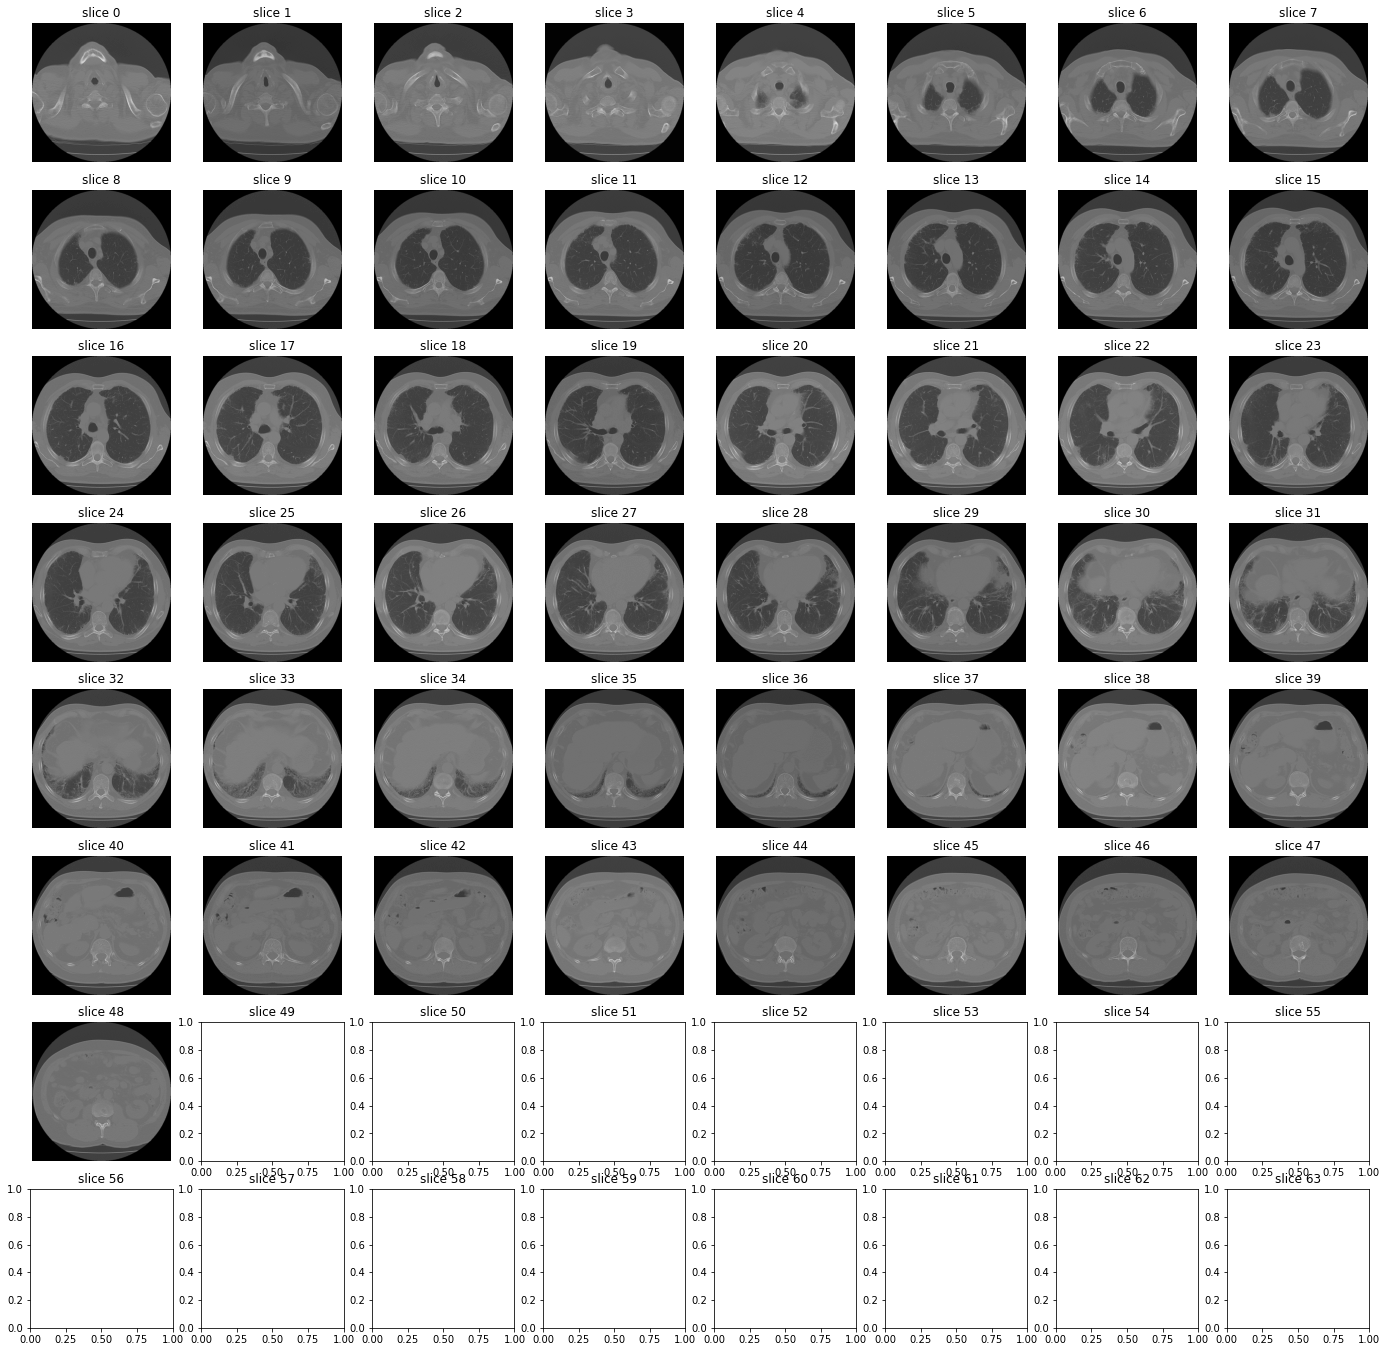

In [63]:
print(len(imgs_to_process))
if len(imgs_to_process) > 100:
    tmp = int(len(imgs_to_process)/10)
    dim = int(np.sqrt(tmp))+1
    show_every = 10
else:
    dim = int(np.sqrt(len(imgs_to_process)))+1
    show_every=1
sample_stack(imgs_to_process, rows=dim, cols=dim, start_with=0, show_every=show_every)

## Processed data published on kaggle

In [64]:
p_id_tmp = "ID00012637202177665765362"
patient_label = "train"
        

../input/osic-pulmonary-fibrosis-progression/archive/mask_noise/mask_noise/ID00012637202177665765362
49


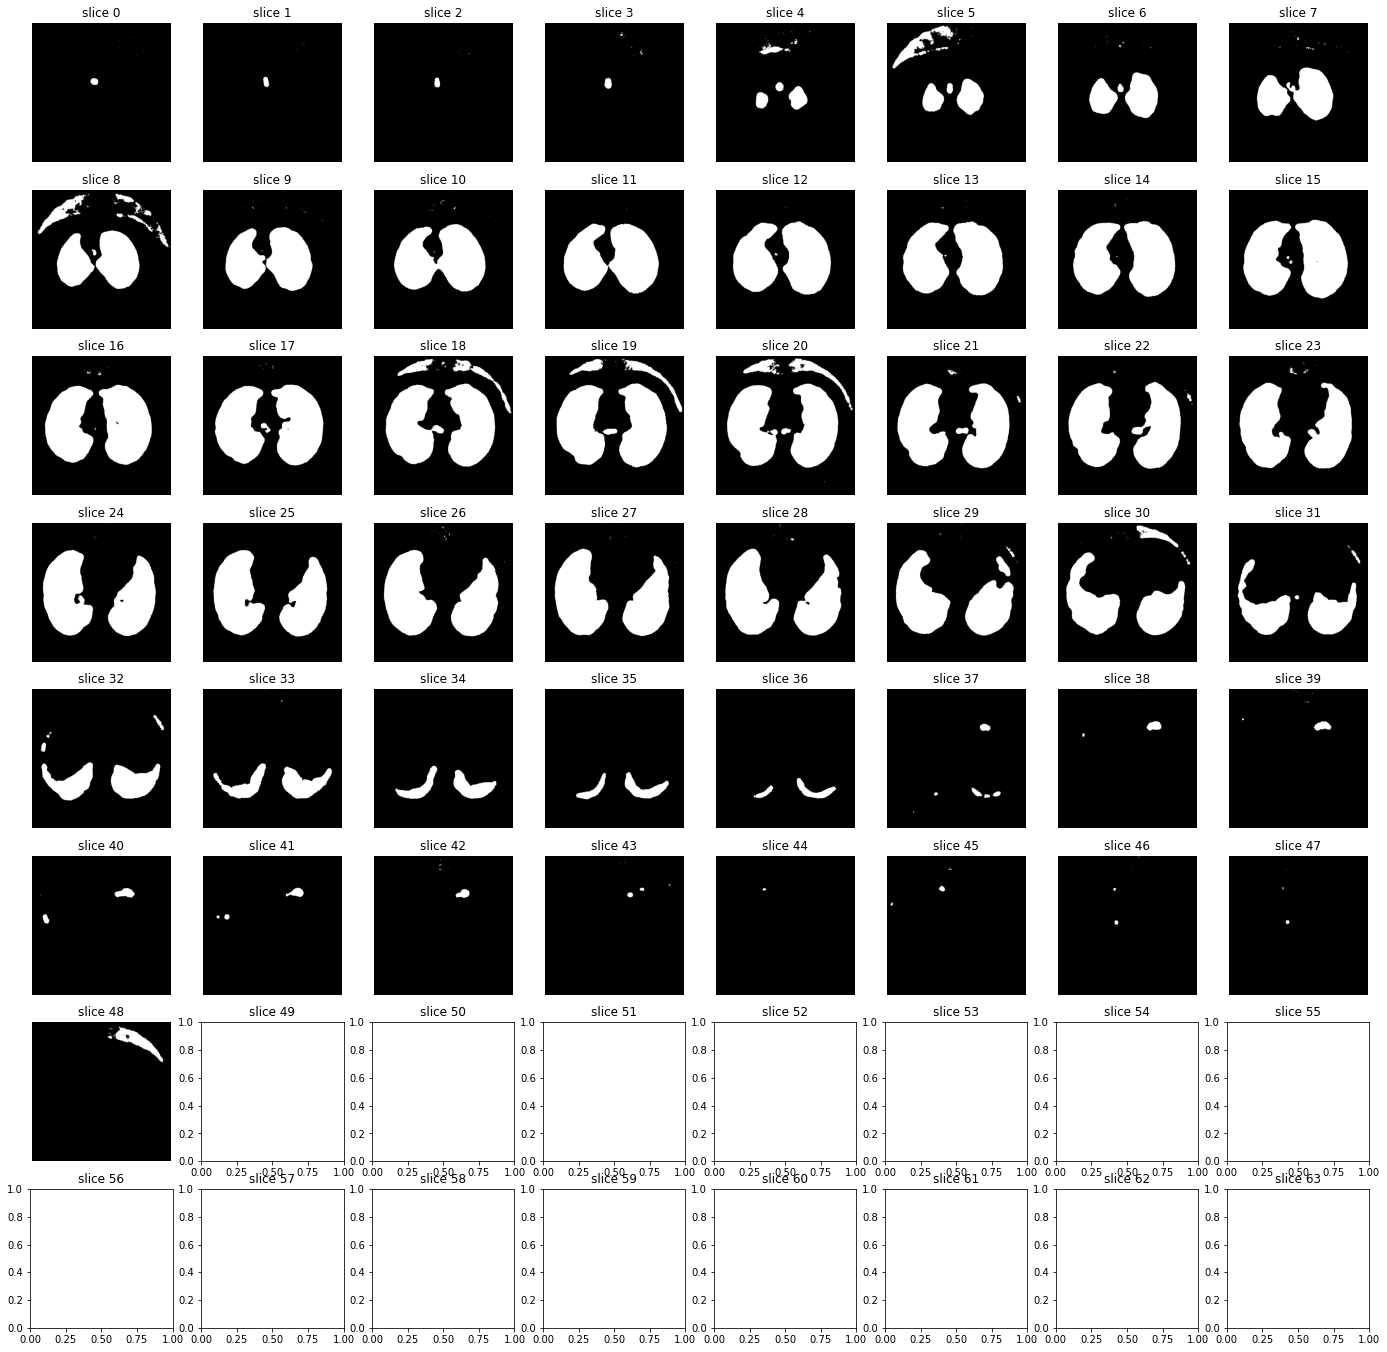

In [65]:
data_path = PROCESSED_DATA_PATH + p_id_tmp
print(data_path)
images = os.listdir(data_path)
sorted_images = sorted(images,key=lambda x: int(os.path.splitext(x)[0]))
slices = [Image.open(f"{PROCESSED_DATA_PATH}/{p_id_tmp}/{sorted_images[index]}") for index, file in enumerate(sorted_images)]
print(len(slices))
if len(slices) > 100:
    tmp = int(len(slices)/10)
    dim = int(np.sqrt(tmp))+1
    show_every = 10
else:
    dim = int(np.sqrt(len(imgs_to_process)))+1
    show_every=1
sample_stack(slices, rows=dim, cols=dim, start_with=0, show_every=show_every)

## Segmentation and lung masks 

In [66]:
p_id_tmp = "ID00012637202177665765362"
patient_label = "train"


- If you are interested in chest CTs because you're interested in picking up lung cancers, you're not alone.

- Machine learning algorithms work a lot better when you can narrowly define what it is looking at. One way to do this is by creating different models for different parts of a chest CT. For instance, a convolutional network for lungs would perform better than a general-purpose network for the whole chest.

- Therefore, it is often useful to pre-process the image data by auto-detecting the boundaries surrounding a volume of interest.

- The UDF below does the following:
    - Standardize the pixel value by subtracting the mean and dividing by the standard deviation
    - Identify the proper threshold by creating 2 KMeans clusters comparing centered on soft tissue/bone vs lung/air.
    - Using Erosion) and Dilation) which has the net effect of removing tiny features like pulmonary vessels or noise
    - Identify each distinct region as separate image labels (think the magic wand in Photoshop)
    - Using bounding boxes for each image label to identify which ones represent lung and which ones represent "every thing else"
    - Create the masks for lung fields.
    - Apply mask onto the original image to erase voxels outside of the lung fields.


### Lung mask UDF

In [69]:
# id = 0
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor    
    image1 = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    print("####################################")
    print(f"Spacing Present in DICOM --> {spacing}")
    print(f"Resize Factor --> {resize_factor}")
    print(f"Raw Image Shape --> {image.shape}")    
    print(f"Resampled Image Shape --> {new_real_shape.shape}")    
    print(f"Real Resize Factor --> {real_resize_factor}")    
    print(f"New Spacing --> {new_spacing}")    
    print("####################################")    
    return image1, new_spacing



Shape before resampling	 (49, 512, 512)
####################################
Spacing Present in DICOM --> [7.    0.625 0.625]
Resize Factor --> [7.    0.625 0.625]
Raw Image Shape --> (49, 512, 512)
Resampled Image Shape --> (3,)
Real Resize Factor --> [7.    0.625 0.625]
New Spacing --> [1. 1. 1.]
####################################
Shape after resampling	 (343, 320, 320)



343


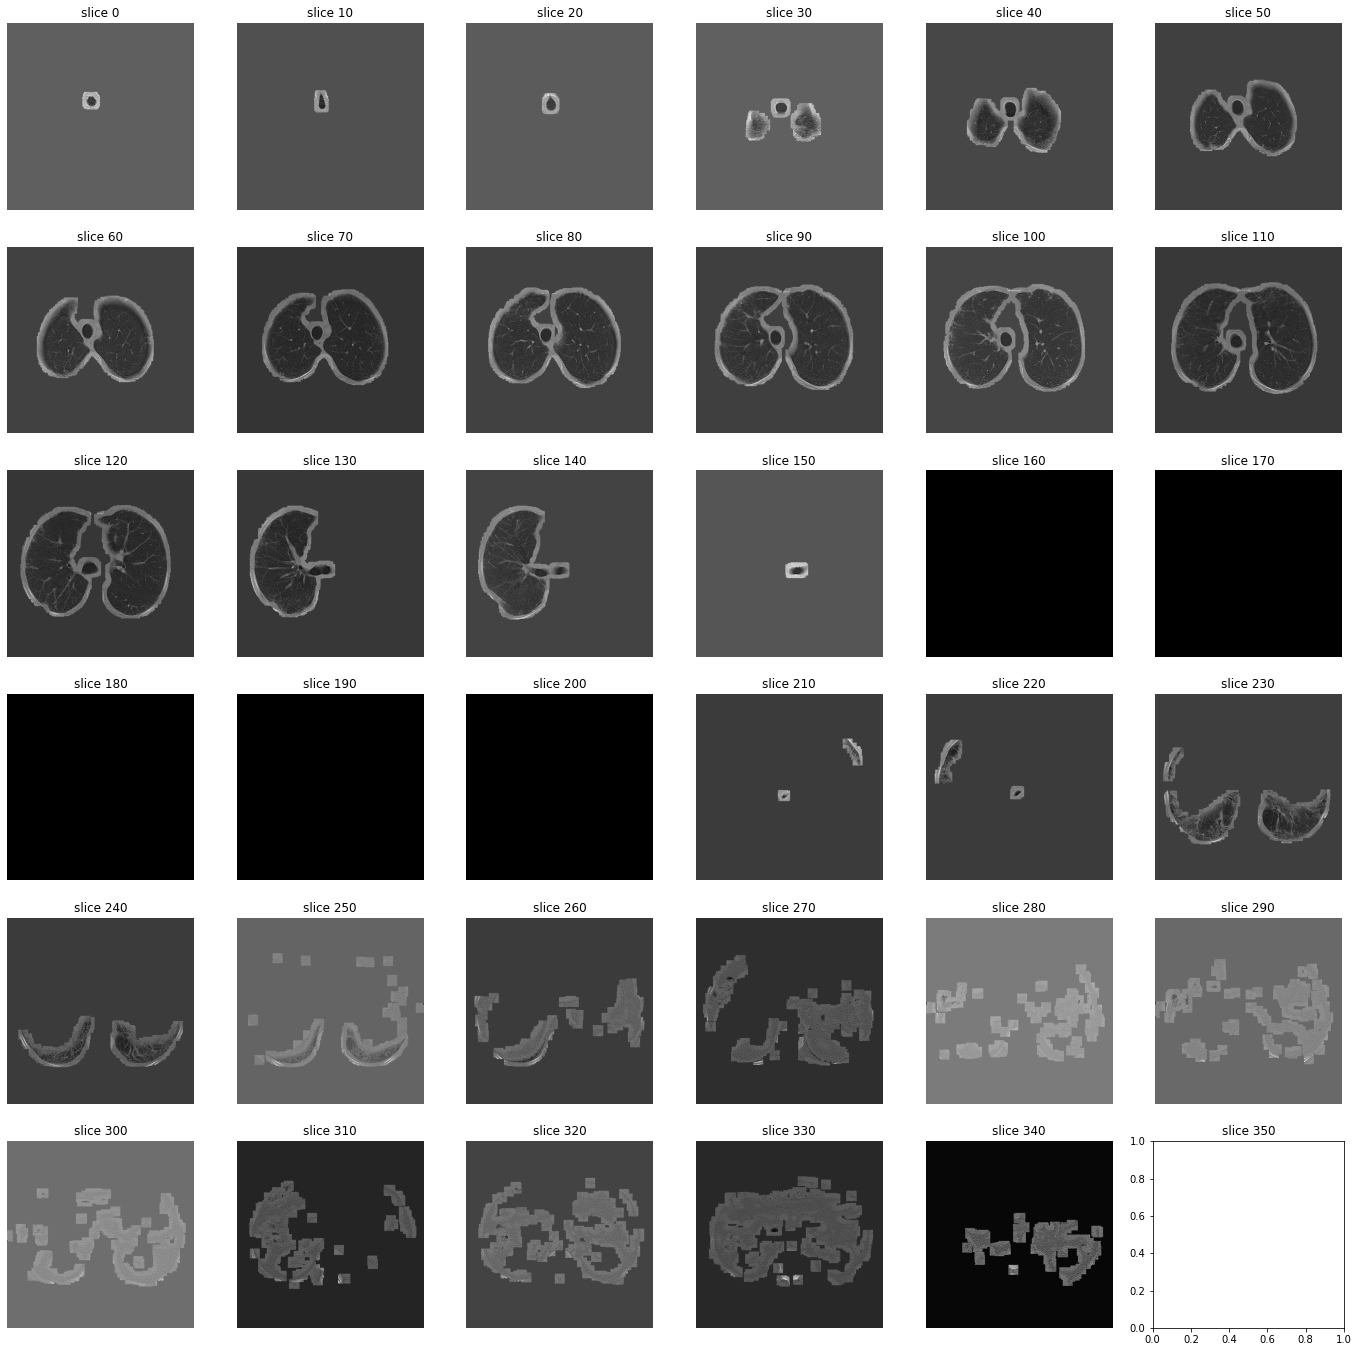

In [70]:
patient = load_scan(PATH, patient_label, p_id_tmp)
imgs_to_process = get_pixels_hu(patient)
print("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)
masked_lung = []
for img in tqdm(imgs_after_resamp):
    masked_lung.append(make_lungmask(img))
print(len(masked_lung))
if len(masked_lung) > 100:
    tmp = int(len(masked_lung)/10)
    dim = int(np.sqrt(tmp))+1
    show_every = 10
else:
    dim=dim, show_every=1
sample_stack(masked_lung, rows=dim, cols=dim, start_with=0, show_every=show_every)


## Average Slice of Images on Lung Mask

### UDF

In [71]:
def average_images(masked_lung, n_imgs):
    print(f"N Images in an array --> {len(masked_lung)}")
    master_arr = []
    master_count = []
    slicer_count = int(len(masked_lung)/n_imgs)+1
    w, h = masked_lung[0].shape
    for i in range(0, len(masked_lung), slicer_count):
        arr1 = np.zeros((h,w), np.float)
        if i + slicer_count <= len(masked_lung):
            for j in range(i, i+slicer_count):
                imarr = np.array(masked_lung[j], dtype=np.float)
                arr1 = arr1+imarr/slicer_count
            master_count.append(slicer_count)
        else:
            print(len(range(i, len(masked_lung))))
            for j in range(i, len(masked_lung)):
                imarr = np.array(masked_lung[j], dtype=np.float)
                arr1 = arr1+imarr/len(range(i, len(masked_lung)))
            master_count.append(len(range(i, len(masked_lung))))
        arr1=np.array(np.round(arr1),dtype=np.float)
        master_arr.append(arr1)
    print(f"## Processed and averaged slices {master_count} at a time images to generate {n_imgs} images")
        
    return master_arr


In [81]:
n_images_to_generate = 8

In [82]:
29 * 11

319

N Images in an array --> 343
42
## Processed and averaged slices [43, 43, 43, 43, 43, 43, 43, 42] at a time images to generate 8 images
8


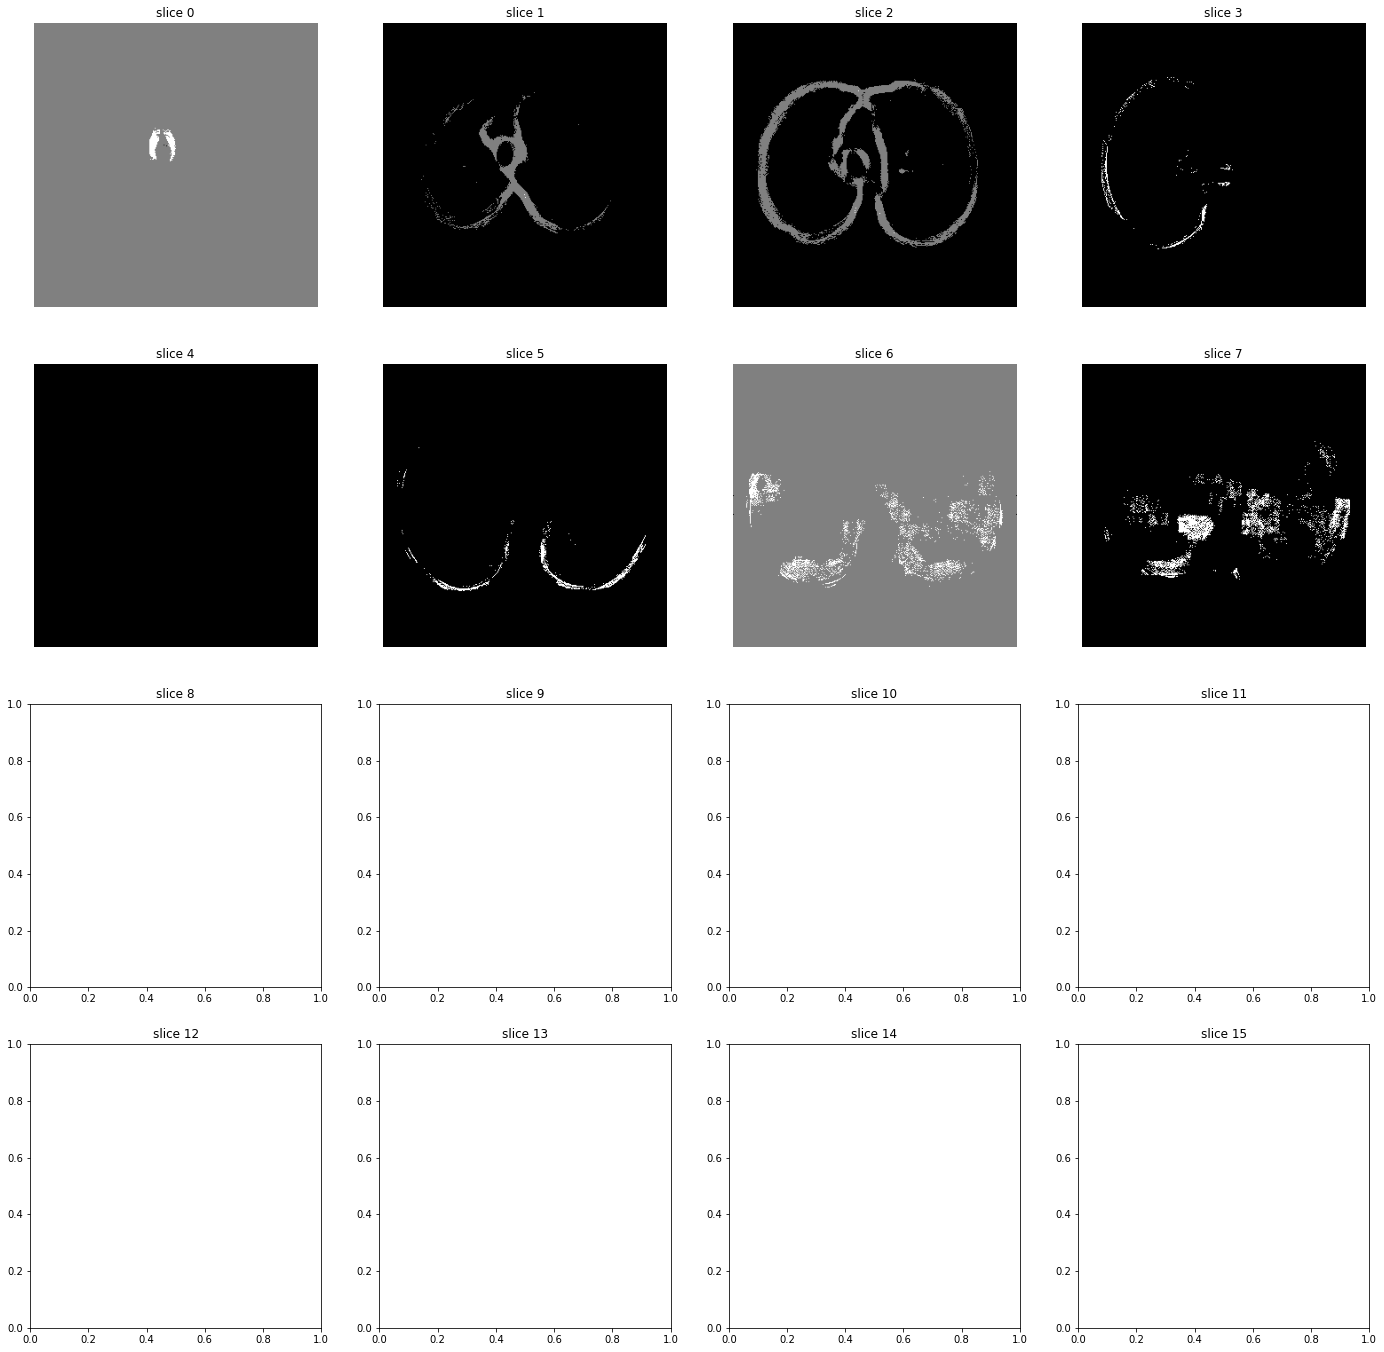

In [83]:
imgs_avg = average_images(masked_lung, n_images_to_generate)
print(len(imgs_avg))
# dim = int(np.sqrt(len(average_images)))
sample_stack(imgs_avg, rows=int(n_images_to_generate/2), cols=int(n_images_to_generate/2), start_with=0, show_every=1)


# playground

In [84]:
# - Image (P)
# - Base FVC (Initial FVC)
# - Meta data
# - week number



# -- FVC for any week

In [ ]:
# def calculateDistance(i1, i2):
#     return numpy.sum((i1-i2)**2)
# calculateDistance(arr, arr1)

# # patient_id = patients_ids[6]
# patient_id = "ID00165637202237320314458"
# print(patient_id)
# images = os.listdir(train_dir + patient_id)
# print(len(images))
# path = f"{train_dir}/{patient_id}/{images[10]}"


# from numpy import asarray
# image = Image.open(path)
# print(image.mode)
# print(image.size)
# image
# # image.show()

# # # convert image to numpy array
# # data = asarray(image)
# # # summarize shape
# # print(data.shape)
# # # convert it back as Pillow Image
# # image2 = Image.fromarray(data)
# # type(image2)
# # image2
# # grey_image = image2.convert(mode='L')
# # grey_image
# # orig_image.size


# print(image.size)
# # create a thumbnail and preserve aspect ratio
# image.thumbnail((64,64))
# print(image.size)
# # resize image and ignore original aspect ratio
# img_resized = image.resize((128,128))
# # report the size of the thumbnail
# print(img_resized.size)
# img_resized

# # images = images[0:4]
# p_id = "ID00165637202237320314458"
# images = sorted(os.listdir(train_dir + "ID00165637202237320314458"))
# print(images)
# print(len(images))
# sorted_images = sorted(images,key=lambda x: int(os.path.splitext(x)[0]))
# sorted_images = sorted_images[0:4]
# # sorted_images = np.random.choice(sorted_images, size=4)
# print(sorted_images)
# result = Image.new("L", (512, 512))

# for index, file in enumerate(sorted_images):
# #   path = os.path.expanduser(file)
#     img = Image.open(path)
#     img.thumbnail((256, 256), Image.ANTIALIAS)
# #     img = img.resize((128,128))

#     x = index // 2 * 256
#     y = index % 2 * 256
#     w, h = img.size
#     print('pos {0},{1} size {2},{3}'.format(x, y, w, h))
#     result.paste(img, (x, y, x + w, y + h))
# result

# # images = images[0:4]
# p_id = "ID00165637202237320314458"
# images = sorted(os.listdir(train_dir + "ID00165637202237320314458"))
# print(images)
# sorted_images = sorted(images,key=lambda x: int(os.path.splitext(x)[0]))
# sorted_images = sorted_images[4:8]
# # sorted_images = np.random.choice(sorted_images, size=4)
# print(sorted_images)
# result = Image.new("L", (512, 512))

# for index, file in enumerate(sorted_images):
# #   path = os.path.expanduser(file)
#     img = Image.open(path)
#     img.thumbnail((256, 256), Image.ANTIALIAS)
# #     img = img.resize((128,128))

#     x = index // 2 * 256
#     y = index % 2 * 256
#     w, h = img.size
#     print('pos {0},{1} size {2},{3}'.format(x, y, w, h))
#     result.paste(img, (x, y, x + w, y + h))
# result

# # images = images[0:4]
# p_id = "ID00165637202237320314458"
# images = sorted(os.listdir(train_dir + "ID00165637202237320314458"))
# print(images)
# sorted_images = sorted(images,key=lambda x: int(os.path.splitext(x)[0]))
# sorted_images = sorted_images[8:12]
# # sorted_images = np.random.choice(sorted_images, size=4)
# print(sorted_images)
# result = Image.new("L", (512, 512))

# for index, file in enumerate(sorted_images):
# #   path = os.path.expanduser(file)
#     img = Image.open(path)
#     img.thumbnail((256, 256), Image.ANTIALIAS)
# #     img = img.resize((128,128))

#     x = index // 2 * 256
#     y = index % 2 * 256
#     w, h = img.size
#     print('pos {0},{1} size {2},{3}'.format(x, y, w, h))
#     result.paste(img, (x, y, x + w, y + h))
# result

In [41]:
p = "/Users/paritoshgupta/Desktop/aamlp/aamlp/input/osic-pulmonary-fibrosis-progression/lung_mask_1mm/ID00025637202179541264076/"
os.chdir(p)
images = os.listdir(p)
filename = images[0]
print(filename)
a = Image.open(images[0], mode='r')
np.array(a).shape

176.png


(342, 342, 4)

In [42]:
from skimage import io
img = io.imread(filename, as_gray=True)

In [45]:
np.min(img)

0.0

In [51]:
a = Image.open(filename).convert('L')
np.max(np.array(a))

255

In [52]:
np.min(np.array(a))

0